In [18]:
import numpy as np
import skimage
from PIL import Image
from skimage.measure import block_reduce
from skimage.color import colorconv
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from IPython.display import clear_output
from time import sleep

In [2]:
def load_maze(path, cell_size):
    maze = skimage.io.imread(path, as_gray=True)
    maze = block_reduce(maze, cell_size, np.max)
    start = tuple(np.argwhere(maze*255==64)[0])
    finish = tuple(np.argwhere(maze*255==128)[0])
    maze[start] = 1.0
    maze[finish] = 1.0
    return maze, start, finish

In [3]:
def coordinate_to_number(coordinate, n_cols):
    return coordinate[0]*n_cols+coordinate[1]

In [119]:
class Agent:
    
    def __init__(self, maze_path, maze_cell_size):
        self.maze, self.start, self.finish = load_maze(maze_path, maze_cell_size)
        self.actionSpace = np.array([
            0, #move up
            1, #move down
            2, #move right
            3  #move left
        ])
        self.q_table = np.zeros((self.maze.size, self.actionSpace.size))
        
    def learn(self, lr=0.1, epochs=100, steps_per_epoch=300, epsilon=0.1):
        
        for i in range(epochs):
            self._reset()
            done = False
            
            for j in range(300):
                maze = self.maze.copy()
                maze[self.pos] = 0.2
                plt.imshow(maze, cmap='gray')
                plt.show()
                print("Epoch: {}\nStep: {}\nPosition: {}".format(i+1, j+1, self.pos))
                

                
                
                actions = self.actionSpace
                
                # Get valid actions that actor can perform from current position
                if self.maze[self.pos] == 1.0:
                    upper_cell = (self.pos[0] - 1, self.pos[1])
                    lower_cell = (self.pos[0] + 1, self.pos[1])
                    right_cell = (self.pos[0], self.pos[1] + 1)
                    left_cell = (self.pos[0], self.pos[1] - 1)
                    
                    if self.maze[upper_cell] == 0.0:
                        actions = np.delete(actions, np.argwhere(actions == self.actionSpace[0]))
                    if self.maze[lower_cell] == 0.0:
                        actions = np.delete(actions, np.argwhere(actions == self.actionSpace[1]))
                    if self.maze[right_cell] == 0.0:
                        actions = np.delete(actions, np.argwhere(actions == self.actionSpace[2]))
                    if self.maze[left_cell] == 0.0:
                        actions = np.delete(actions, np.argwhere(actions == self.actionSpace[3]))
                        
                # Select action to perform
                if np.random.uniform() < epsilon:
                    action = np.random.choice(actions)
                else:
                    state_n = coordinate_to_number(self.pos, self.maze.shape[1])
                    action = actions[np.argmax(np.take(self.q_table[state_n], actions))]
                
                
                
                
                if self._step(action, lr):
                    clear_output(wait=True)
                    break
                clear_output(wait=True)
        if (i+1)%5 == 0:
            epsilon -= 0.005
        
    def _reset(self):
        self.pos = self.start
        self.pos_prev = None
        
    def _step(self, action, lr):
        gamma = 0.7
        
        reward = 10
        penalty = -1
        
        
        if action == 0:
            new_pos = (self.pos[0]-1, self.pos[1])
        if action == 1:
            new_pos = (self.pos[0]+1, self.pos[1])
        if action == 2:
            new_pos = (self.pos[0], self.pos[1]+1)
        if action == 3:
            new_pos = (self.pos[0], self.pos[1]-1)
        
        state_curr = coordinate_to_number(self.pos, self.maze.shape[1])
        state_new = coordinate_to_number(new_pos, self.maze.shape[1])
        
        if new_pos == self.pos_prev:
            self.q_table[(state_curr, action)] = (1-lr) * self.q_table[(state_curr, action)] + \
                                                 lr * (penalty + gamma * np.max(self.q_table[state_new]))
            print("PENALTY!")
        else:
            self.q_table[(state_curr, action)] = (1-lr) * self.q_table[(state_curr, action)] + \
                                                 lr * (reward + gamma * np.max(self.q_table[state_new]))
            print("REWARD!!!")
            
        self.pos_prev = self.pos
        self.pos = new_pos
        done = self.pos == self.finish
        
        return done
        
    def qtable_to_pandas(self):
        df = pd.DataFrame({
            'up': self.q_table[:, 0],
            'down': self.q_table[:, 1],
            'right': self.q_table[:, 2],
            'left': self.q_table[:, 3],
        })
        df.index.name = 'state'
        return df
        
        

In [101]:
agent = Agent('maze2.png', (32, 32))

In [102]:
agent.qtable_to_pandas().head()

,up,down,right,left
state,,,,
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


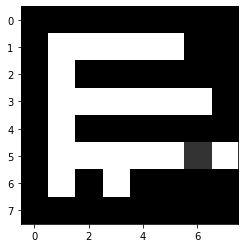

Epoch: 99
Step: 9
Position: (5, 6)
REWARD!!!


In [103]:
agent.learn()

In [104]:
pd_qtable = agent.qtable_to_pandas()

In [105]:
pd_qtable[(pd_qtable.up != 0) | (pd_qtable.down != 0) | (pd_qtable.right != 0) | (pd_qtable.left != 0)]

,up,down,right,left
state,,,,
9,0.000000,30.438896,4.018450,0.000000
10,0.000000,0.000000,2.411360,6.382484
11,0.000000,0.000000,0.722085,1.306971
12,0.000000,0.000000,0.429521,0.743725
13,0.000000,0.000000,0.000000,-0.466142
17,5.078514,29.714905,0.000000,0.000000
25,-0.030000,28.639333,1.000000,0.000000
26,0.000000,0.000000,0.514145,2.243854
27,0.000000,0.000000,0.327355,0.521212


In [110]:
agent2 = Agent('maze3.png', (1, 1))

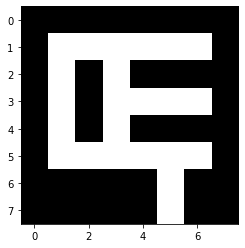

In [111]:
plt.imshow(agent2.maze, cmap='gray')

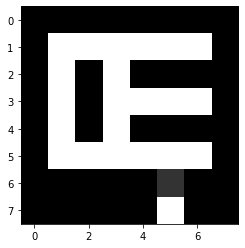

Epoch: 99
Step: 13
Position: (6, 5)
REWARD!!!


In [112]:
agent2.learn(epsilon=0.2)

In [ ]:
agent2.

In [120]:
agent3 = Agent('maze4.png', (1,1))

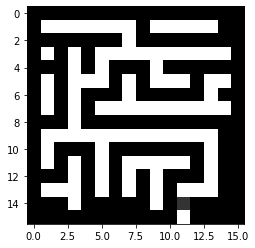

Epoch: 200
Step: 48
Position: (14, 11)
REWARD!!!


In [121]:
agent3.learn(epochs=200, epsilon=0.25)

In [122]:
agent3.qtable_to_pandas()

,up,down,right,left
state,,,,
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000
